***Single-Agent Q-learning***

In [120]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
import gym
from gym import spaces

In [121]:
class GridWorldEnv(gym.Env):
    """
    Custom 2D Grid World environment in Gym.
    Gym is for building and testing RL environments.
    """

    def __init__(self, grid_size=(3, 3), start=(0, 0), goal=(2, 2), gamma = 0.9):
        super(GridWorldEnv, self).__init__()

        # Define the grid world size
        self.grid_size = grid_size

        # Define start and goal positions
        self.start = start
        self.goal = goal

        # Set the current position to the start
        self.agent_pos = np.array(self.start)

        # Define action space: 4 possible actions (up, down, left, right)
        # spaces.Discrete is used to create a space of a finite set of elements
        self.action_space = spaces.Discrete(4)  # 0 = down, 1 = left, 2 = up, 3 = right

        # Define observation space (agent's position in the grid)
        # cartesian product of n closed intervals
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(2,), dtype=np.int32)

        # State-value function initialized to 0
        self.V = np.zeros(self.grid_size)

        # Initialize the policy (a random policy for now, can be updated later)
        # Policy: a 5x5 grid where each entry is one of the actions (0=down, 1=left, 2=up, 3=right)
        self.policy = np.random.choice([0, 1, 2, 3], size=self.grid_size)

        # Define discount rate
        self.gamma = gamma

        # Define the movement directions corresponding to actions
        self.movement = {
            0: np.array([1, 0]),  # down
            1: np.array([0, -1]),  # left
            2: np.array([-1, 0]),  # up
            3: np.array([0, 1])  # right
        }

    def reset(self):
        """
        Reset the environment to the initial state (start position).
        """
        self.agent_pos = np.array(self.start)
        return self.agent_pos

    def step(self, action):
        """
        Perform an action and update the environment's state.
        """
        # Update the agent's position
        next_pos = self.agent_pos + self.movement[action]

        # Check if the new position is within grid bounds
        if self._is_valid(next_pos):
            self.agent_pos = next_pos

        # Check if the agent has reached the goal
        if tuple(self.agent_pos) == self.goal:
            reward = 10  # Large reward for reaching the goal
            done = True
        else:
            reward = -1  # Small step penalty
            done = False

        return self.agent_pos, reward, done, {}

    def _is_valid(self, pos):
        """
        Check if the new position is valid (within bounds).
        """
        # Check if position is within bounds
        if 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1]:
            return True
        return False


In [122]:
def q_learning(env, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.1):
    # initializing Q table with zeros 
    Q = np.zeros((*env.grid_size, env.action_space.n)) # every cell contains the Q value for choosing a certain action

    # start of episode (place the agent at the start and set done to false)
    for episode in range(episodes):
        state = tuple(env.reset())  # Reset environment
        done = False

        while not done:
            # Choose action using epsilon-greedy policy
            if np.random.rand() < epsilon:
                action = env.action_space.sample()  # Explore
            else:
                action = np.argmax(Q[state])  # Exploit best known action

            # Take action and observe next state & reward
            next_state, reward, done, _ = env.step(action)
            next_state = tuple(next_state)

            # Q-value update using Bellman equation
            Q[state + (action,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action,)])

            # Move to the next state
            state = next_state

        # Optional: Print progress
        if episode % 100 == 0:
            print(f"Episode {episode} completed.")

    return Q


# Train the agent
env = GridWorldEnv()
Q_table = q_learning(env)
print("Training complete! Learned Q-table:")
print(Q_table)

Episode 0 completed.
Episode 100 completed.
Episode 200 completed.
Episode 300 completed.
Episode 400 completed.
Episode 500 completed.
Episode 600 completed.
Episode 700 completed.
Episode 800 completed.
Episode 900 completed.
Training complete! Learned Q-table:
[[[ 3.94779643  2.86328749  2.82325357  4.58      ]
  [ 6.2         2.85645494  3.9752183   4.88678643]
  [ 7.88614977  0.78190921  0.49372008  0.38727052]]

 [[-0.4784419   0.04470452 -0.07862704  6.16128523]
  [ 6.63741629  3.64618029  4.02067428  8.        ]
  [10.          5.74727649  4.51878674  7.57648756]]

 [[-0.199      -0.199      -0.199       0.8423302 ]
  [ 0.27953279 -0.1        -0.1         9.69096846]
  [ 0.          0.          0.          0.        ]]]


In [123]:
def extract_policy(Q):
    """
    Extracts the optimal policy from the Q-table.
    """
    policy = np.argmax(Q, axis=-1)  # Best action for each state
    return policy

optimal_policy = extract_policy(Q_table)
print("Optimal Policy:")
print(optimal_policy)

Optimal Policy:
[[3 0 0]
 [3 3 0]
 [3 3 0]]


In [124]:
def plot_grid_with_policy(env):
    """This method plots the environment of the agent and shows the policy arrows.
    Works for grid environments.

    Args:
        env (GridWorldEnv): The environment to be plotted.
    """
    # Create a copy of the environment grid
    grid = np.zeros(env.grid_size)

    # Define custom colors for the colormap
    colors = ['white', 'black']  # 'white' for free cells
    cmap = mcolors.ListedColormap(colors)

    # Plot the grid with the custom colormap
    fig, ax = plt.subplots()
    ax.matshow(grid, cmap=cmap)

    # Display 'F' for the finish line
    ax.text(env.goal[1], env.goal[0], 'F', ha='center', va='center', color='black', fontsize=20)
    ax.text(env.start[1], env.start[0], 'S', ha='center', va='center', color='black', fontsize=20)

    # Define arrow directions based on policy actions
    action_arrows = {
        0: '↓',  # down
        1: '←',  # left
        2: '↑',  # up
        3: '→'   # right
    }

    # Place arrows on the grid based on the policy
    for i in range(env.grid_size[0]):
        for j in range(env.grid_size[1]):
            if (i, j) == env.goal:
                continue
            action = optimal_policy[i, j]  # Get action for the current state
            ax.text(j, i, action_arrows[action], ha='center', va='center', color='blue', fontsize=20)

    # Add grid lines separating each square
    ax.set_xticks(np.arange(-0.5, env.grid_size[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
    ax.set_xticks([])
    ax.set_yticks([])

    plt.title("Grid World with Optimal Policy Arrows")
    plt.show()

def plot_value_function(env):
    """Plot the value function with respect to an end point, including grid lines."""
    grid = env.V.copy()

    # Create a new figure
    plt.figure()

    # Plot the grid representing the value function
    plt.imshow(grid, cmap='Purples', interpolation='nearest', aspect='auto')
    plt.colorbar()
    plt.title("Agent's value function")

    # Add grid lines to the plot
    ax = plt.gca()  # Get the current axis
    ax.set_xticks(np.arange(-0.5, env.grid_size[1], 1), minor=True)
    ax.set_yticks(np.arange(-0.5, env.grid_size[0], 1), minor=True)
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)  # Add the grid lines

    # Hide the tick labels (optional, for a cleaner plot)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    return plt


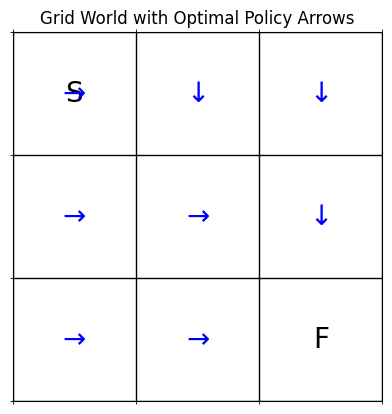

In [125]:
# Initialize the environment
env = GridWorldEnv(grid_size=(3, 3), start=(0, 0), goal=(2, 2))

# Plotting a random policy
plot_grid_with_policy(env)

# we get now the random initialized policy

***Multi-Agent Q-learning***

Fix a policy for all except one agent that learns through Q-learning

In [126]:
class MultiAgentGridWorldEnv(gym.Env):
    """
    Multi-agent Grid World environment where one agent learns while others follow fixed policies.
    """
    def __init__(self, grid_size=(3, 3), agent_start_goals=[((2, 0), (0, 0)), ((2, 2), (0, 2))]):
        super(MultiAgentGridWorldEnv, self).__init__()

        self.grid_size = grid_size
        self.agent_start_goals = agent_start_goals  

        self.agent_positions = [np.array(start) for start, _ in self.agent_start_goals]
        self.goals = [goal for _, goal in self.agent_start_goals]

        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=max(grid_size), shape=(len(agent_start_goals), 2), dtype=np.int32)

        self.movement = {
            0: np.array([1, 0]),  # down
            1: np.array([0, -1]),  # left
            2: np.array([-1, 0]),  # up
            3: np.array([0, 1])  # right
        }


    def reset(self):
        """ Reset agent positions. """
        self.agent_positions = [np.array(start) for start, _ in self.agent_start_goals]  
        return np.array(self.agent_positions)

    def step(self, action_learning, action_fixed):
        """ Perform a step where both agents take actions. """
        rewards = [0, 0]  # Ensure default values exist for both agents
        done_flags = [False, False]  # Ensure both agents have a done flag

        new_positions = self.agent_positions.copy()

        # Process learning agent (agent 0 or 1 depending on who is learning)
        next_pos_learning = self.agent_positions[0] + self.movement[action_learning]
        if self._is_valid(next_pos_learning):
            new_positions[0] = next_pos_learning

        # Process fixed agent
        next_pos_fixed = self.agent_positions[1] + self.movement[action_fixed]
        if self._is_valid(next_pos_fixed):
            new_positions[1] = next_pos_fixed

        # Check for collisions
        position_counts = {tuple(pos): 0 for pos in new_positions}
        for pos in new_positions:
            position_counts[tuple(pos)] += 1

        for i in range(len(self.agent_positions)):
            if position_counts[tuple(new_positions[i])] > 1:  # Collision detected
                rewards[i] = -10  # Penalty for collision
                new_positions[i] = self.agent_positions[i]  # Bounce back to previous position
            elif tuple(new_positions[i]) == self.goals[i]:  # Reached goal
                rewards[i] = 100
                done_flags[i] = True
            else:  # Step penalty
                rewards[i] = -1
                done_flags[i] = False

        self.agent_positions = new_positions
        
        return np.array(self.agent_positions), rewards[0], done_flags[0], {}




    def _is_valid(self, pos):
        """ Check if position is within grid bounds. """
        return 0 <= pos[0] < self.grid_size[0] and 0 <= pos[1] < self.grid_size[1]


In [127]:
def generate_fixed_policy_left(env, agent_idx, exploration_prob=0.8):
    """ 
    Generate a fixed policy where the agent mostly moves left but occasionally explores.
    
    - `exploration_prob`: Probability of choosing a random action instead of always moving left.
    """
    policy = np.ones(env.grid_size, dtype=int)  # Set default action to "Move Left" (1)

    # Introduce small randomness
    for x in range(env.grid_size[0]):
        for y in range(env.grid_size[1]):
            if np.random.rand() < exploration_prob:  # With probability `exploration_prob`, explore
                policy[x, y] = np.random.choice([0, 1, 2, 3])  # Random action
            else:
                policy[x, y] = 1  # Default to moving left

    return policy

In [128]:
env = MultiAgentGridWorldEnv()
fixed_policy_a2 = generate_fixed_policy(env, 1)
fixed_policy_a2

array([[3, 3, 0],
       [2, 2, 2],
       [2, 2, 2]])

In [129]:
def q_learning(env, learning_agent_idx, fixed_policy, episodes=1000, alpha=0.1, gamma=0.9, epsilon=0.5):
    """
    Generalized Q-learning for either agent in a multi-agent environment.
    
    - `learning_agent_idx`: which agent (0 or 1) is learning.
    - `fixed_policy`: precomputed policy for the fixed agent.
    """
    Q = np.zeros((*env.grid_size, env.action_space.n))  # Initialize Q-table

    for episode in range(episodes):
        state = tuple(env.reset()[learning_agent_idx])  # Get the learning agent's position
        done = False

        while not done:
            if np.random.rand() < epsilon:
                action_learning = env.action_space.sample()  # Explore
            else:
                action_learning = np.argmax(Q[state])  # Exploit best known action

            # Get the fixed agent's action from the fixed policy
            fixed_agent_idx = 1 if learning_agent_idx == 0 else 0
            fixed_action = fixed_policy[tuple(env.agent_positions[fixed_agent_idx])]

            # Step in the environment
            next_positions, reward, done, _ = env.step(action_learning, fixed_action)
            next_state = tuple(next_positions[learning_agent_idx])  # Update learning agent's position

            # Q-value update using Bellman equation
            Q[state + (action_learning,)] += alpha * (reward + gamma * np.max(Q[next_state]) - Q[state + (action_learning,)])

            state = next_state

        if episode % 100 == 0:
            print(f"Agent {learning_agent_idx} - Episode {episode} completed.")

    return Q


In [130]:
def extract_policy(Q):
    """ Extracts the optimal policy from the Q-table. """
    return np.argmax(Q, axis=-1) 

optimal_policy = extract_policy(Q_table)
optimal_policy

array([[3, 0, 0],
       [3, 3, 0],
       [3, 3, 0]], dtype=int64)

In [131]:
Q1 = q_learning(env, learning_agent_idx=0, fixed_policy=fixed_policy_a2)
extract_policy(Q1)

Agent 0 - Episode 0 completed.
Agent 0 - Episode 100 completed.
Agent 0 - Episode 200 completed.
Agent 0 - Episode 300 completed.
Agent 0 - Episode 400 completed.
Agent 0 - Episode 500 completed.
Agent 0 - Episode 600 completed.
Agent 0 - Episode 700 completed.
Agent 0 - Episode 800 completed.
Agent 0 - Episode 900 completed.


array([[0, 1, 1],
       [2, 1, 1],
       [2, 1, 1]], dtype=int64)

**Alternating Nash Q-learning**

We now want to alternate between the two agents. First agent 1 will train ang agent 2 will follow a fixed policy and then wel'll do the opposite and keep alternating. This alternating approach will generate a big nash gap.

In [138]:
def compute_nash_gap(Q1, Q2):
    """
    Compute the Nash gap as the difference between:
    - The best possible Q-value in a state (optimal response)
    - The Q-value under the current strategy.
    """
    nash_gap = 0

    for state in np.ndindex(Q1.shape[:-1]):  # Iterate over all states
        a1_best = np.argmax(Q1[state])  # Agent 1's best action
        a2_best = np.argmax(Q2[state])  # Agent 2's best action

        # Compute the gap between the current action and the optimal one
        gap_1 = np.max(Q1[state]) - np.mean(Q1[state])
        gap_2 = np.max(Q2[state]) - np.mean(Q2[state])

        nash_gap += (gap_1 + gap_2)  # Sum of both agents' deviations

    return nash_gap / np.prod(Q1.shape[:-1])  # Normalize over all states


In [139]:
def alternating_q_learning(env, cycles=5, episodes=100, alpha=0.1, gamma=0.9, epsilon=0.5):
    """
    Alternates training between Agent 1 and Agent 2 over multiple cycles.
    
    - `cycles`: Number of times to alternate between training A1 and A2.
    - `episodes`: Number of episodes per agent per cycle.
    """
    Q1 = np.zeros((*env.grid_size, env.action_space.n))  # Initialize Q-table for A1
    Q2 = np.zeros((*env.grid_size, env.action_space.n))  # Initialize Q-table for A2
    nash_gaps = []  # Track Nash gap progression

    for cycle in range(cycles):
        print(f"\n Cycle {cycle + 1}: Training Agent 1 while Agent 2 is fixed")

        # Step 1: Train Agent 1 (A1) while A2 follows a fixed heuristic policy
        fixed_policy_a2 = generate_fixed_policy_left(env, agent_idx=1, exploration_prob=0.5) if cycle == 0 else np.argmax(Q2, axis=-1)
        old_policy_a1 = np.argmax(Q1, axis=-1).copy()
        Q1 = q_learning(env, learning_agent_idx=0, fixed_policy=fixed_policy_a2, episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)

        print(f"\n Cycle {cycle + 1}: Training Agent 2 while Agent 1 is fixed")

        # Step 2: Train Agent 2 (A2) while A1 follows the learned policy
        fixed_policy_a1 = np.argmax(Q1, axis=-1)
        old_policy_a2 = np.argmax(Q2, axis=-1).copy()
        Q2 = q_learning(env, learning_agent_idx=1, fixed_policy=fixed_policy_a1, episodes=episodes, alpha=alpha, gamma=gamma, epsilon=epsilon)

        # Compute and store the Nash gap after each cycle
        nash_gap_value = compute_nash_gap(Q1, Q2)
        nash_gaps.append(nash_gap_value)
        print(f"Nash Gap after Cycle {cycle + 1}: {nash_gap_value}")

        # Track policy changes
        policy_change_a1 = np.sum(old_policy_a1 != np.argmax(Q1, axis=-1))
        policy_change_a2 = np.sum(old_policy_a2 != np.argmax(Q2, axis=-1))
        print(f"Policy Changes - Agent 1: {policy_change_a1} states, Agent 2: {policy_change_a2} states")

    return Q1, Q2, nash_gaps

env = MultiAgentGridWorldEnv()
Q1_final, Q2_final, nash_gaps = alternating_q_learning(env, cycles=5, episodes=1000)



 Cycle 1: Training Agent 1 while Agent 2 is fixed
Agent 0 - Episode 0 completed.
Agent 0 - Episode 100 completed.
Agent 0 - Episode 200 completed.
Agent 0 - Episode 300 completed.
Agent 0 - Episode 400 completed.
Agent 0 - Episode 500 completed.
Agent 0 - Episode 600 completed.
Agent 0 - Episode 700 completed.
Agent 0 - Episode 800 completed.
Agent 0 - Episode 900 completed.

 Cycle 1: Training Agent 2 while Agent 1 is fixed
Agent 1 - Episode 0 completed.
Agent 1 - Episode 100 completed.
Agent 1 - Episode 200 completed.
Agent 1 - Episode 300 completed.
Agent 1 - Episode 400 completed.
Agent 1 - Episode 500 completed.
Agent 1 - Episode 600 completed.
Agent 1 - Episode 700 completed.
Agent 1 - Episode 800 completed.
Agent 1 - Episode 900 completed.
Nash Gap after Cycle 1: 35.07475224385793
Policy Changes - Agent 1: 8 states, Agent 2: 6 states

 Cycle 2: Training Agent 1 while Agent 2 is fixed
Agent 0 - Episode 0 completed.
Agent 0 - Episode 100 completed.
Agent 0 - Episode 200 completed

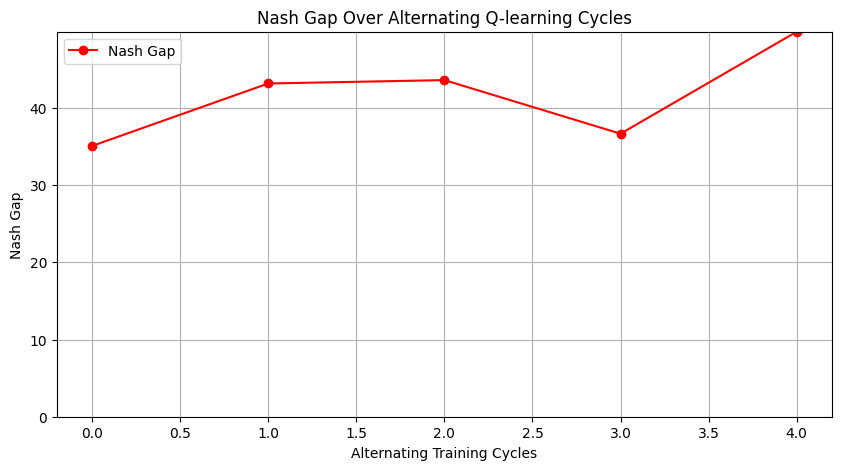

In [142]:
plt.figure(figsize=(10, 5))
plt.plot(nash_gaps, marker="o", linestyle="-", color="red", label="Nash Gap")
y_min, y_max = min(nash_gaps), max(nash_gaps)
y_abs_max = max(abs(y_min), abs(y_max))  
plt.ylim(0, y_abs_max)
plt.xlabel("Alternating Training Cycles")
plt.ylabel("Nash Gap")
plt.title("Nash Gap Over Alternating Q-learning Cycles")
plt.legend()
plt.grid(True)
plt.show()